# Import Packages

In [290]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

# Plotting and Metric Score

In [291]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()


def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

def plot_ts_y(ts_x, ts_y, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts_x, label=ts_x)
    plt.plot(ts_y, label=ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

# Data Preprocessing

In [292]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_values(by='DAY_ID')
y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID')

x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')

In [293]:
X.head()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,NaN,0.650577,NaN,-0.650577,...,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003
1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,...,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047
1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
111,2,DE,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,...,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,...,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756


In [294]:
X.columns

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

In [295]:
y.head()

,TARGET
ID,
1054,0.028313
2049,-0.112516
1924,-0.180840
297,-0.260356
1101,-0.071733


In [296]:
x_validation.head()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,-0.519419,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,-0.555367,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,-0.666901,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,0.205276,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,0.240856,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


# Missing Data

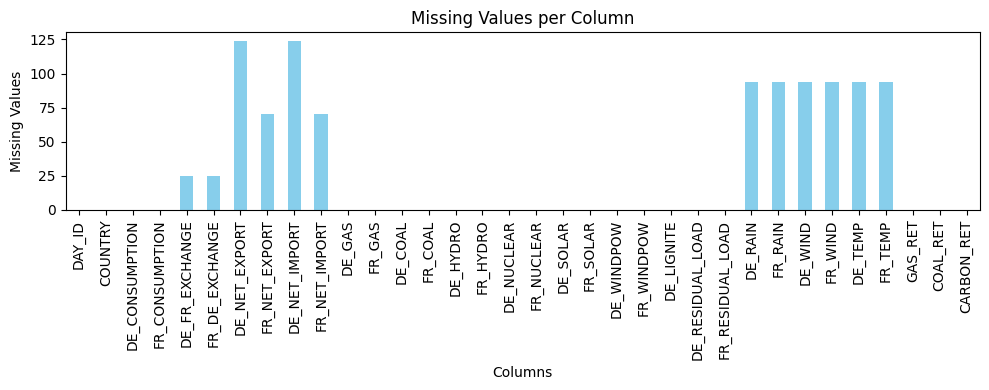

In [297]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Fill Data

In [298]:
X.interpolate(method='polynomial',order=2, inplace=True)
#X = X.fillna(method='ffill')  # Forward Fill Missing Data
X = X.fillna(method='bfill')  # Backward Fill introduces lookahead bias
X = pd.get_dummies(X, columns=['COUNTRY'])  # One Hot Encoding for each country

#y = pd.merge(X[['ID']], y, on='ID')  # Align the ID column of X and y
y = X.join(y)[['TARGET']] # Align the ID column of X and y

x_validation.interpolate(method='polynomial',order=2, inplace=True)
#x_validation = x_validation.fillna(method='ffill') # Forward Fill the Missing Data
x_validation = x_validation.fillna(method='bfill') # Backward Fill introduces lookahead bias
x_validation = pd.get_dummies(x_validation, columns=['COUNTRY']) # One Hot Encoding for each country

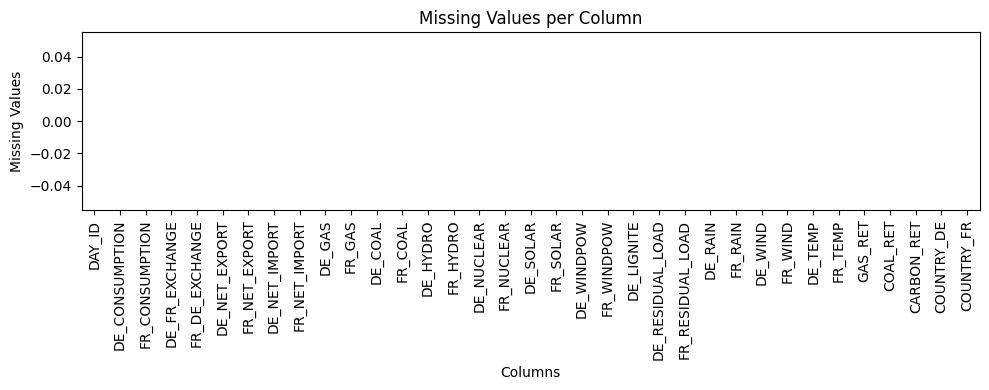

In [299]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Feature Engineering

<Figure size 1000x500 with 0 Axes>

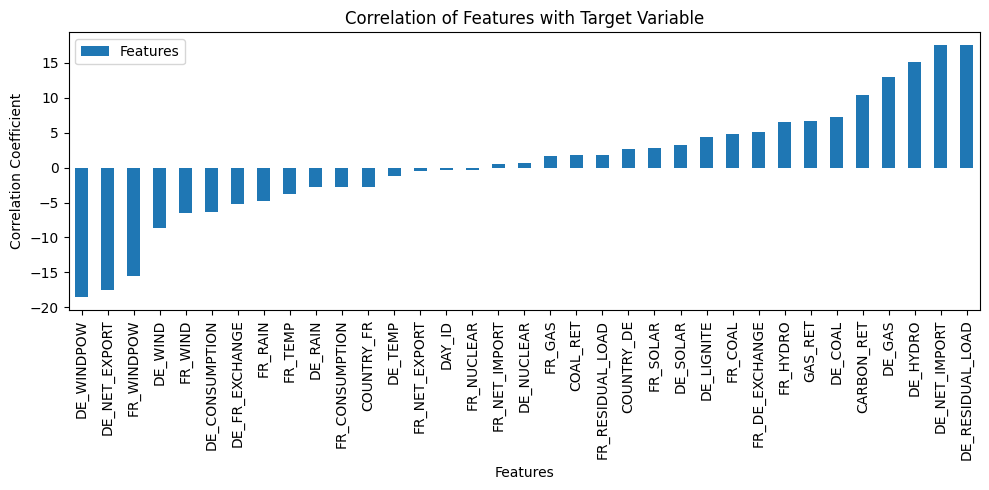

In [300]:
correlation = [metric_train(X[col], y['TARGET']) for col in X.columns]
correlation_df = pd.DataFrame(correlation, index=X.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [301]:
low_corr = correlation_df[abs(correlation_df['Features']) < 2.5]
low_corr

,Features
DAY_ID,-0.390095
FR_NET_EXPORT,-0.527141
FR_NET_IMPORT,0.527141
FR_GAS,1.633355
DE_NUCLEAR,0.705175
FR_NUCLEAR,-0.361857
FR_RESIDUAL_LOAD,1.824129
DE_TEMP,-1.230593
COAL_RET,1.757295


In [302]:
columns_to_keep = ['COUNTRY_DE', 'COUNTRY_FR']
columns_to_drop = [column for column in low_corr.index if column not in columns_to_keep]
X_dropped = X.drop(columns=columns_to_drop)

<Figure size 1000x500 with 0 Axes>

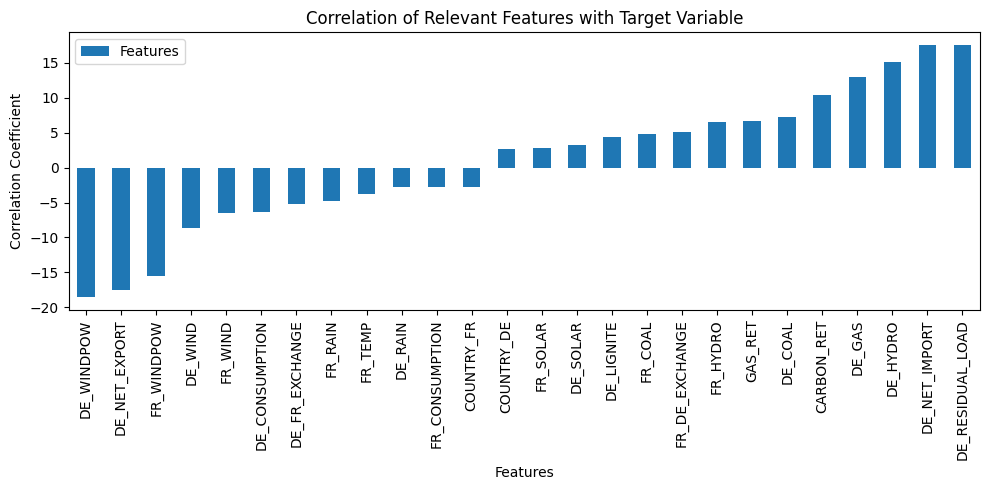

In [303]:
new_correlation = [metric_train(X_dropped[col], y['TARGET']) for col in X_dropped.columns]
new_correlation_df = pd.DataFrame(new_correlation, index=X_dropped.columns, columns=['Features'])
plt.figure(figsize=(10, 5))
new_correlation_df.sort_values(by='Features').plot(kind='bar', figsize=(10,5))
plt.title('Correlation of Relevant Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [323]:
new_correlation_df.sort_values(by='Features')

,Features
DE_WINDPOW,-18.568799
DE_NET_EXPORT,-17.568035
FR_WINDPOW,-15.556754
DE_WIND,-8.645661
FR_WIND,-6.439799
DE_CONSUMPTION,-6.361683
DE_FR_EXCHANGE,-5.145011
FR_RAIN,-4.788535
FR_TEMP,-3.764611
DE_RAIN,-2.837149


### Plot of every feature against TARGET

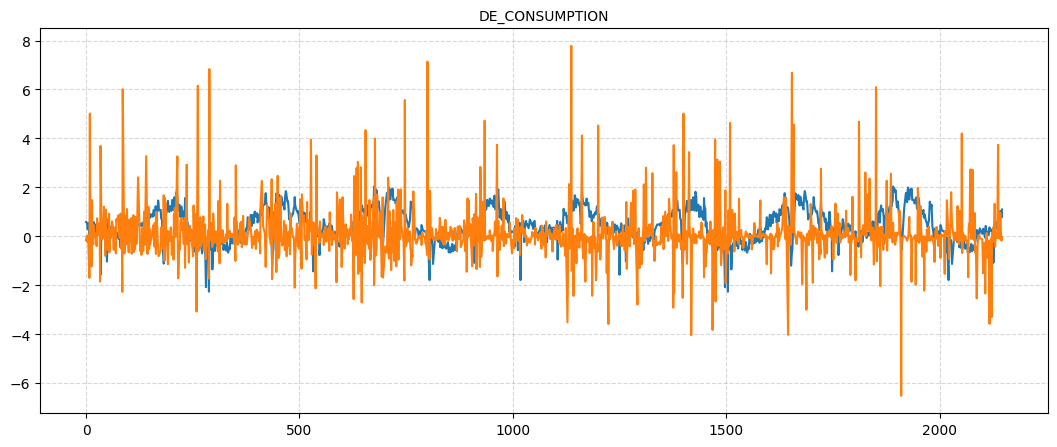

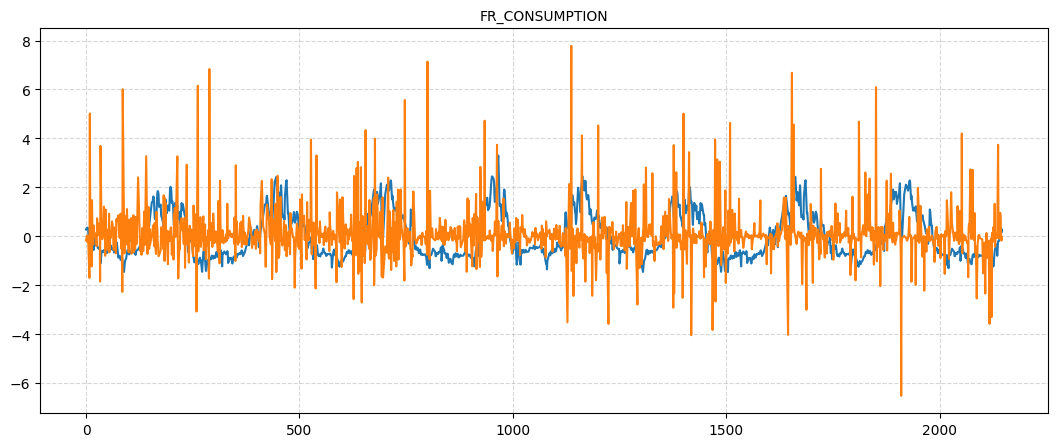

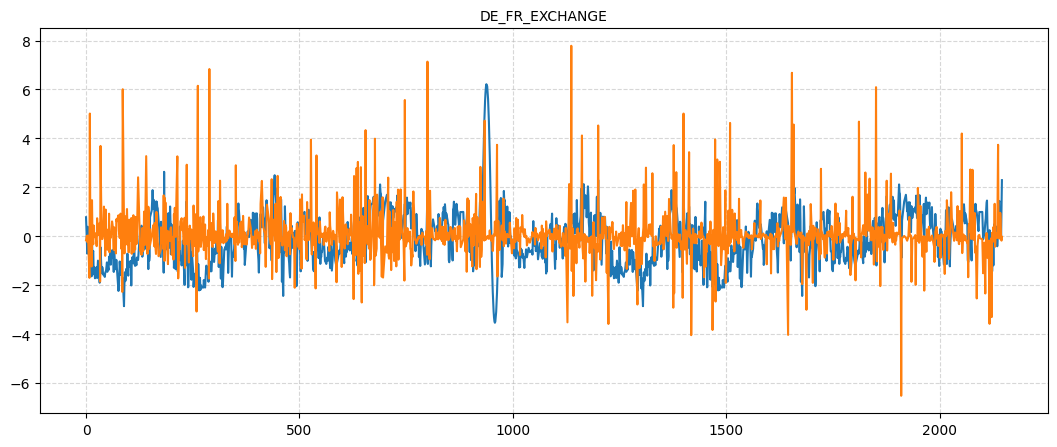

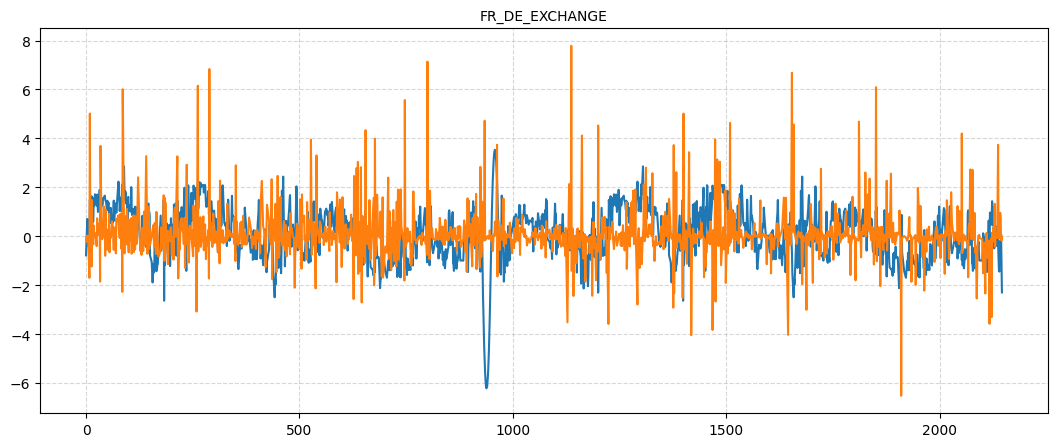

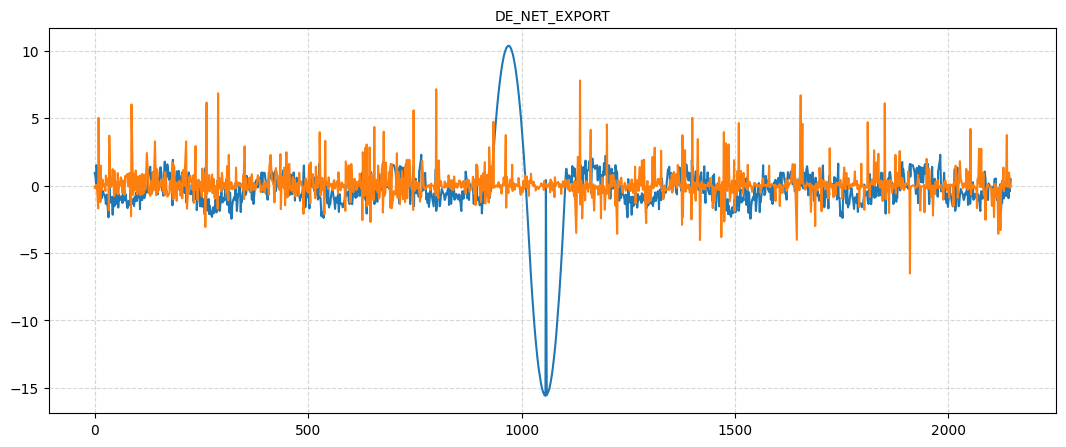

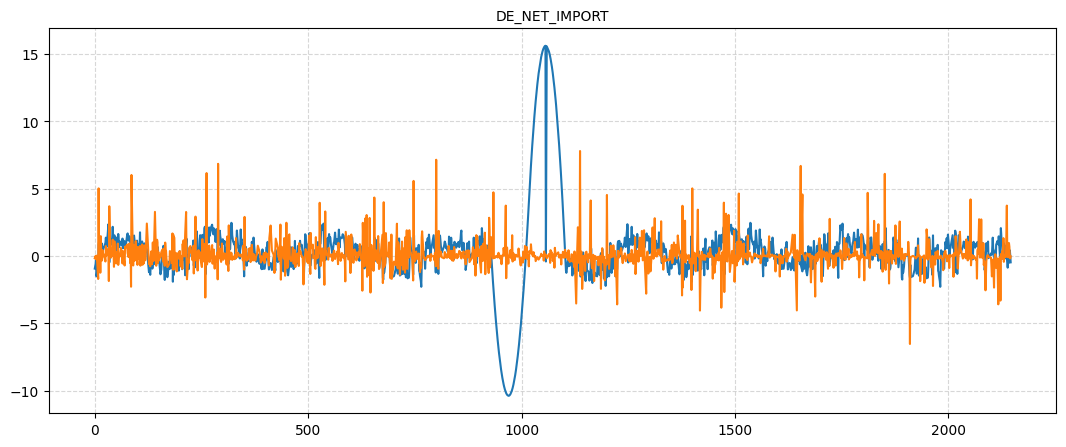

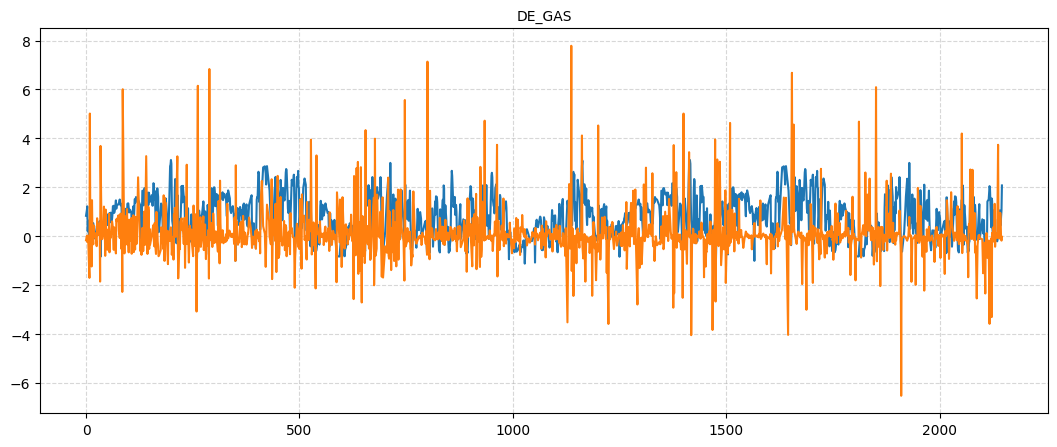

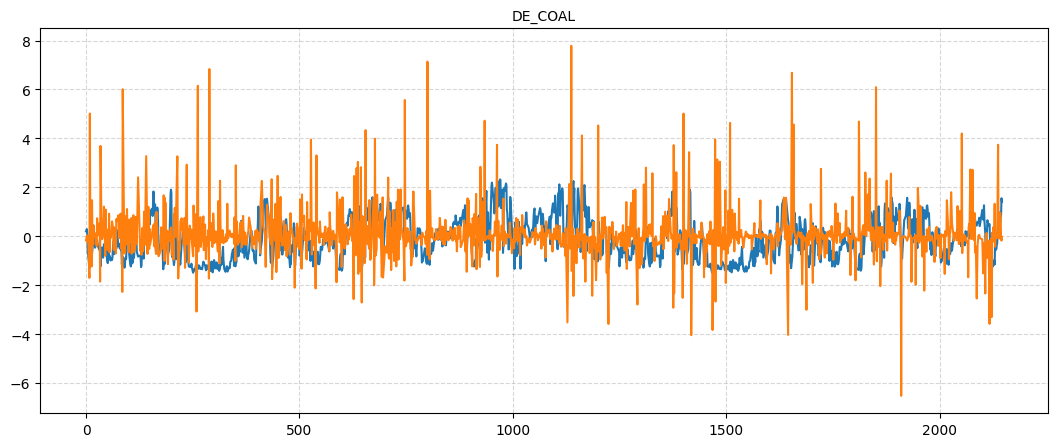

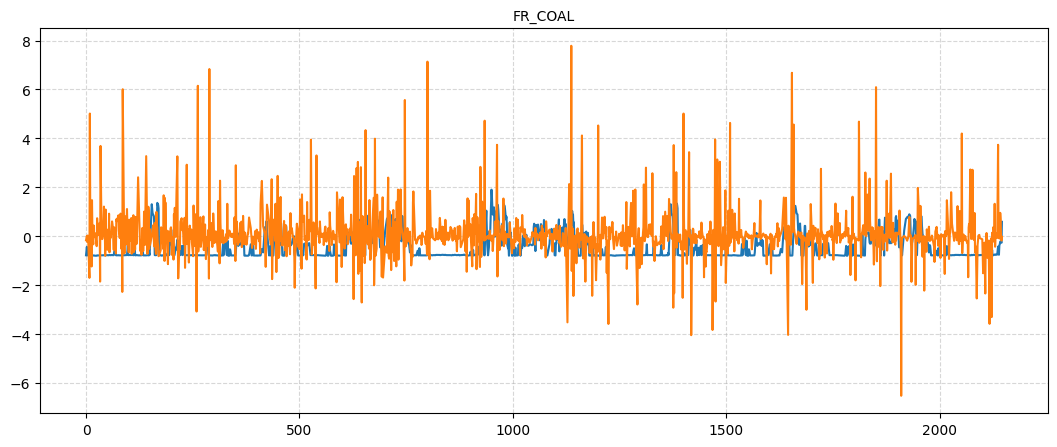

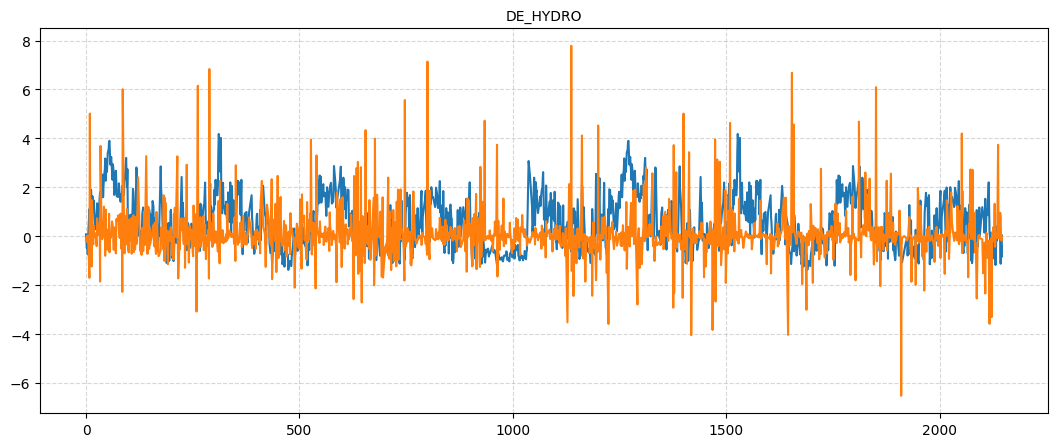

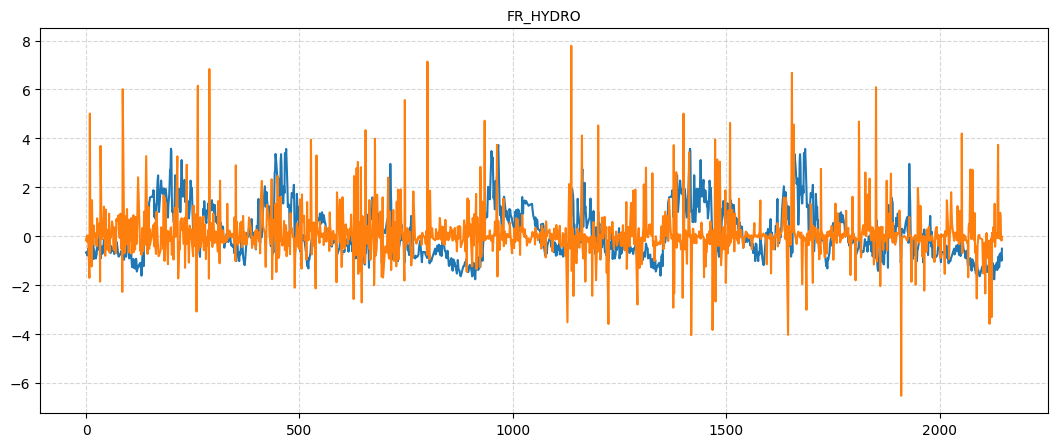

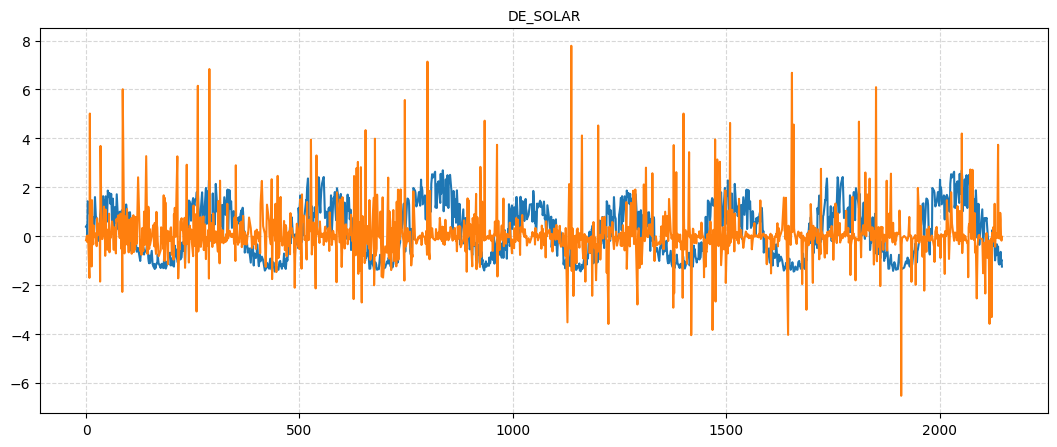

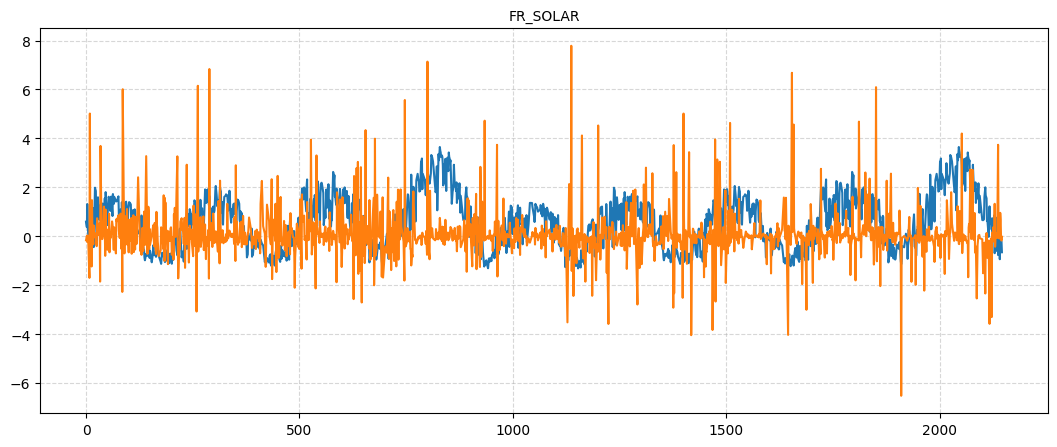

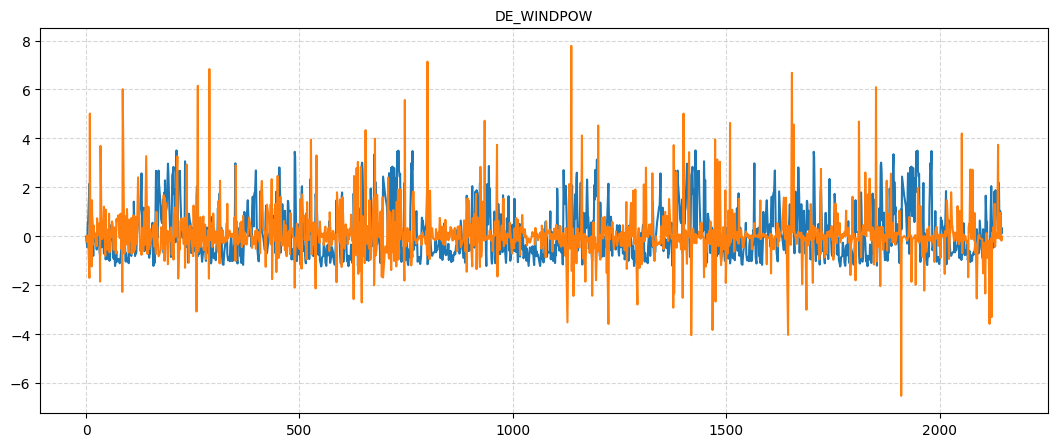

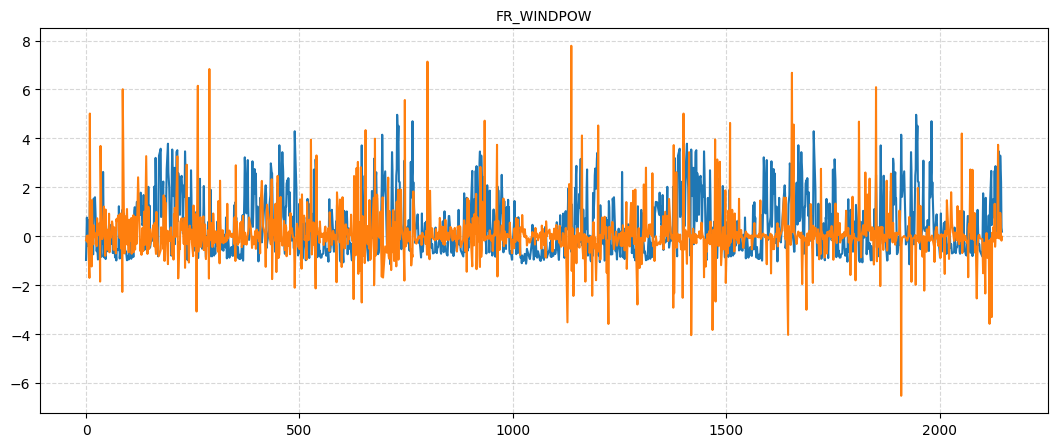

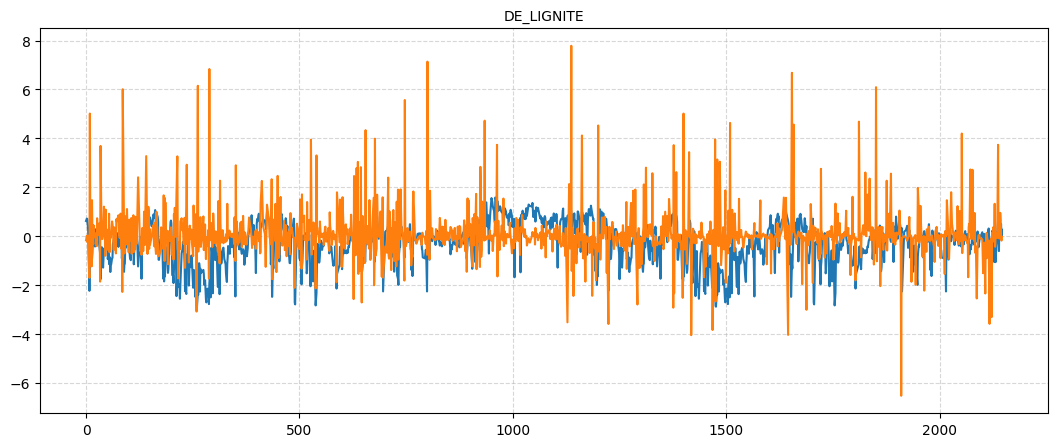

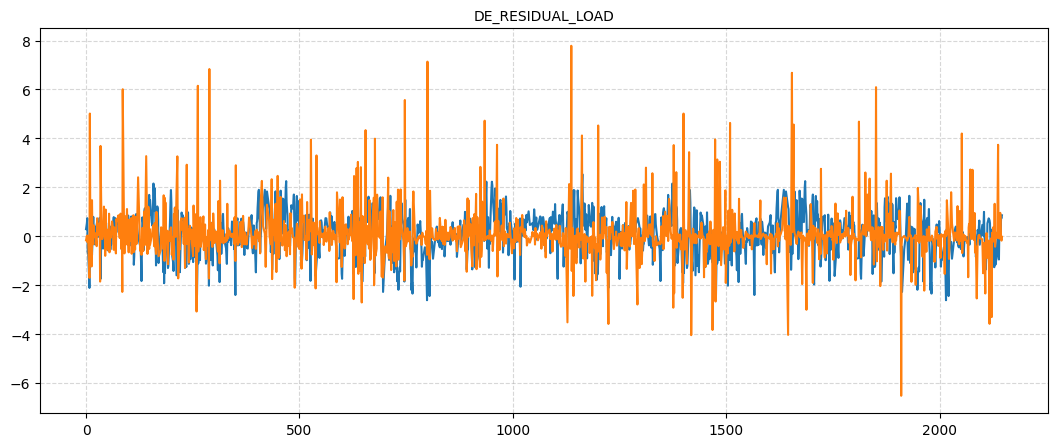

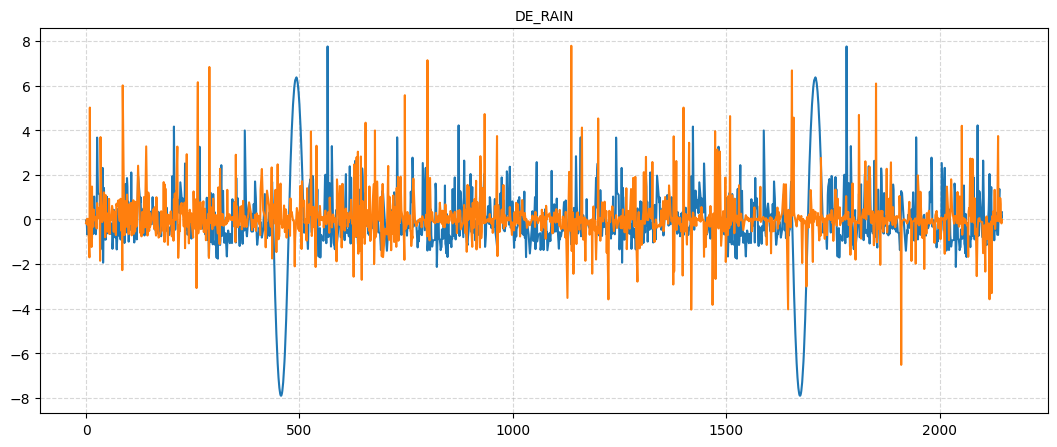

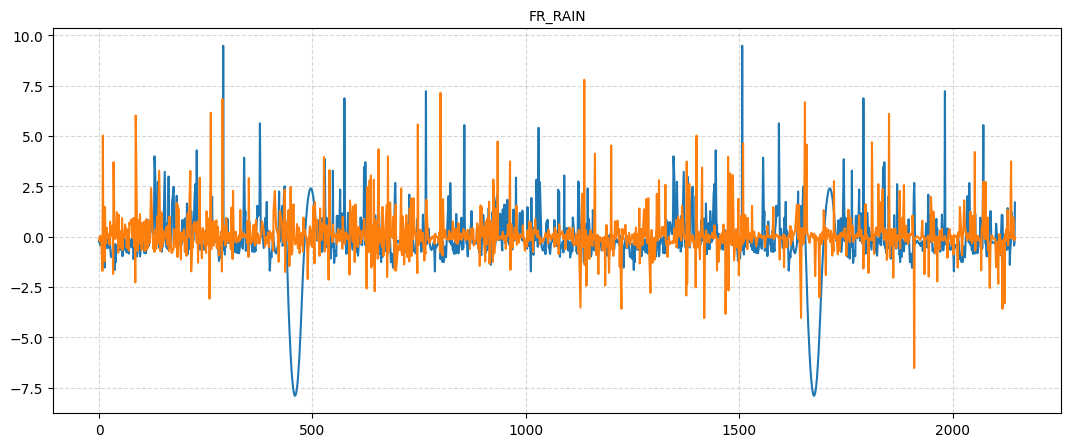

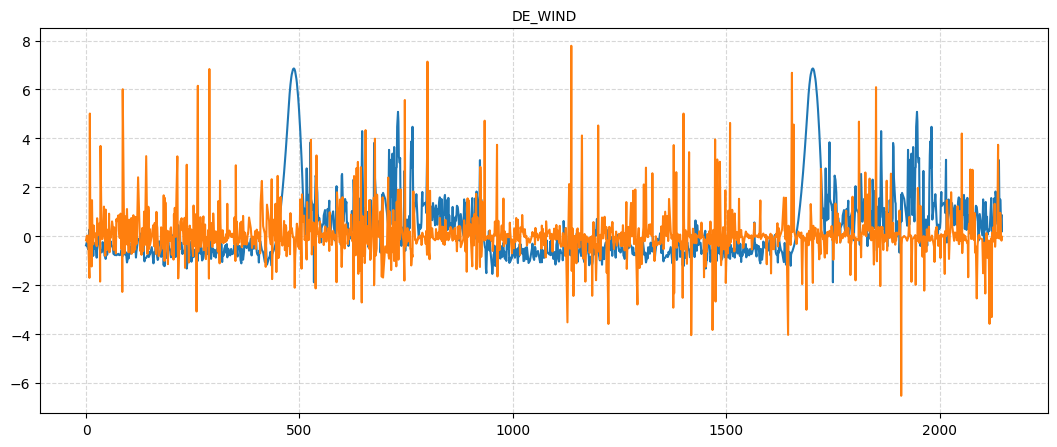

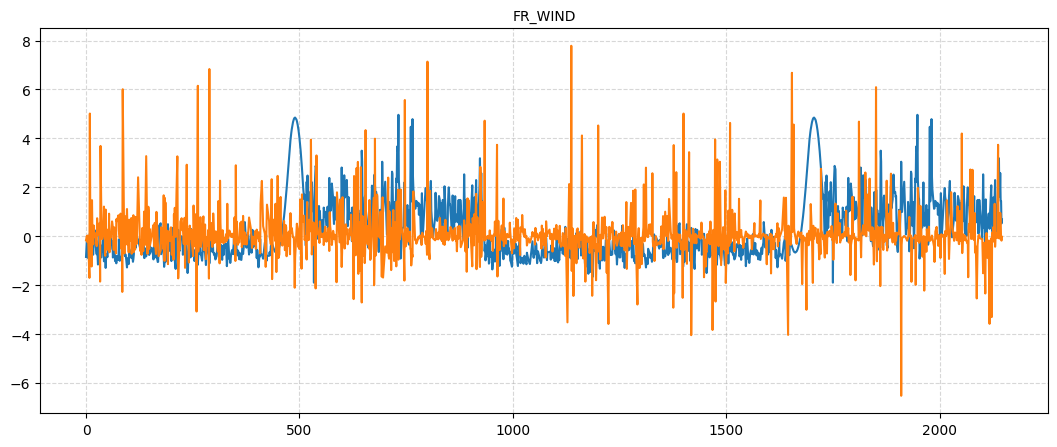

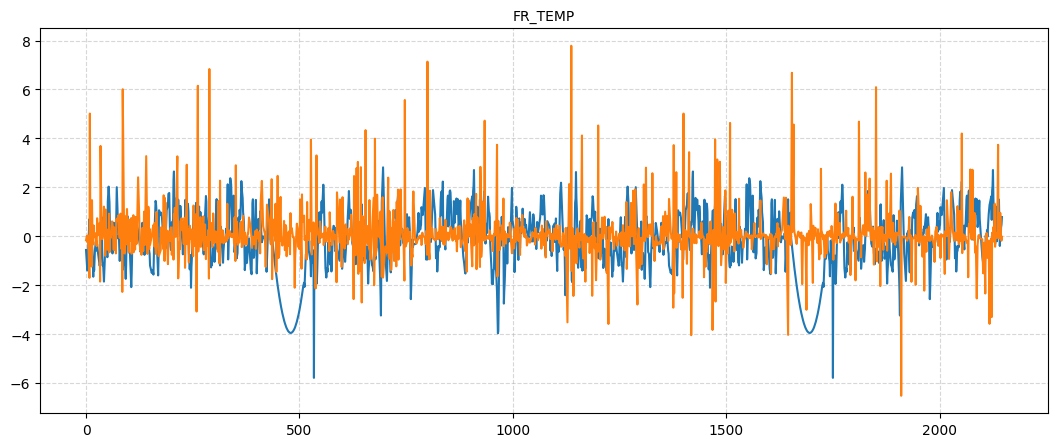

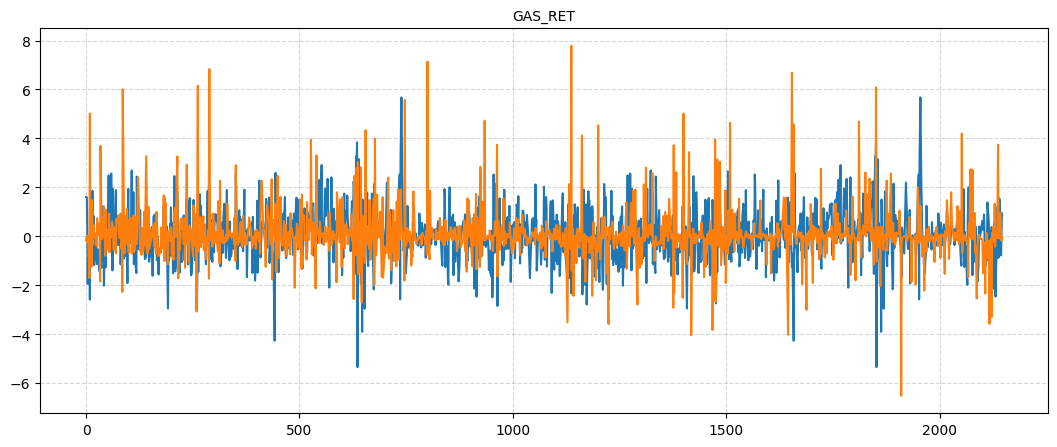

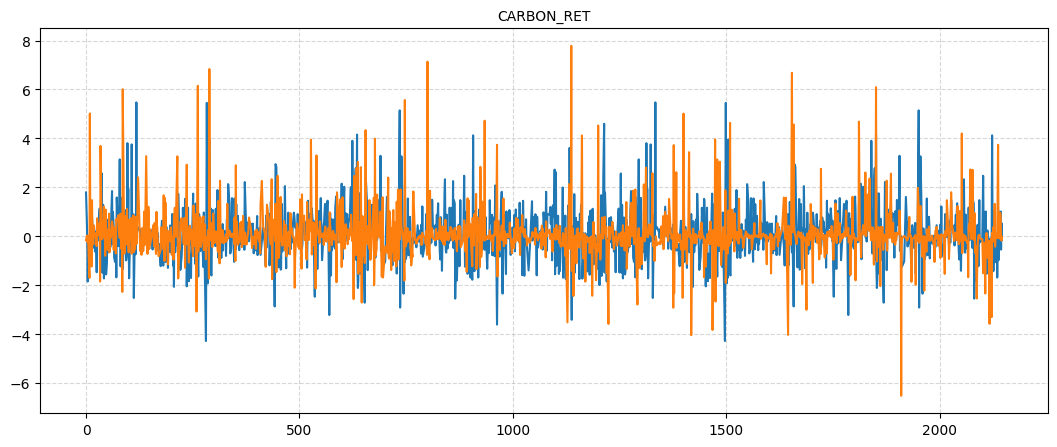

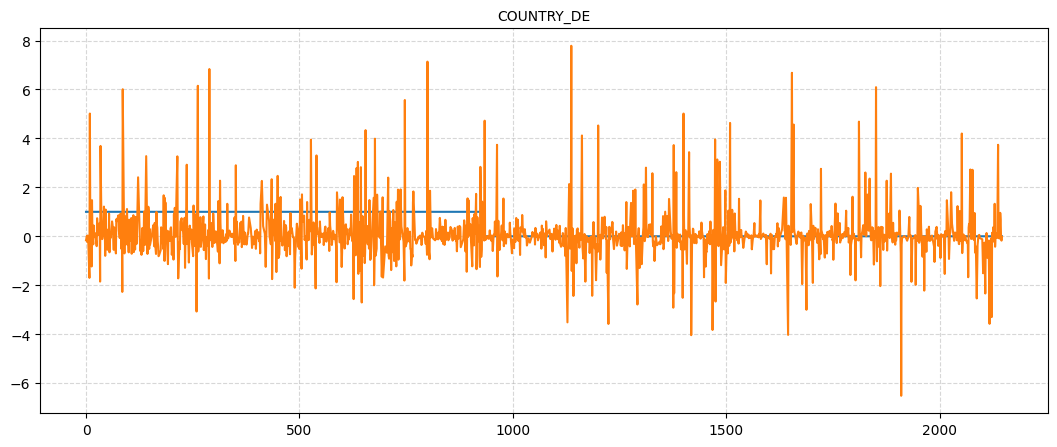

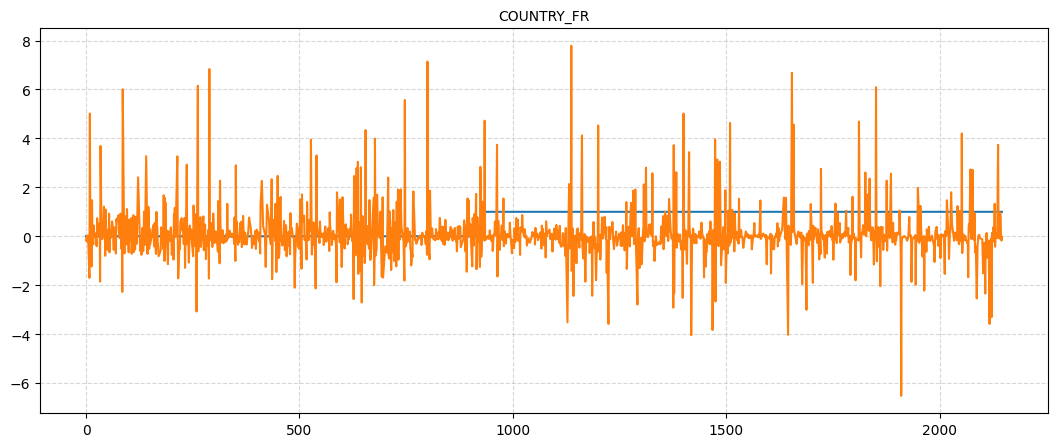

In [304]:
X_plot = X_dropped.copy(deep=True)
X_plot = X_plot.sort_index()
y_plot = y.copy(deep=True)
y_plot = y_plot.sort_index()
# Plot all data to find patterns
for col in X_plot.columns:
    if col == 'DAY_ID':
        continue
    plot_ts_y(X_plot[col], y_plot['TARGET'], title=col)

## Cross Validation for MSE using XGBRegressor

In [305]:
# Cross Validation for MSE using XGBRegressor
def XGBRegressorCrossValidationMSE(X_clean, Y_clean):
    """ Return the Cross Validated Prameters for XGBRegressor for MSE"""
    # X_clean and Y_clean must be processed already
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Standardize each data set
    #X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    #X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

    # Define  parameter grid
    """
    param_grid = {
        #'colsample_bytree': [None, 0.3, 0.4, 0.5, 0.6],
        #'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [None, 10, 15],
        'alpha': [5, 10, 15],
        'n_estimators': [50, 100, 200]
    }
    """
    param_grid = {
    'max_depth': [10, 15],
    'alpha': [10],
    'n_estimators': [100, 200],
    #'learning_rate': [0.01, 0.1]#,
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6]#,
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.5, 0.75, 1]
    }
    
    xgb_reg = XGBRegressor(objective='reg:squarederror')

    # SGridSearchCV with the scoring minimizing MSE
    cv_method = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, 
                            scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X_train, y_train)

    # Best parameters 
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))

    training_prediction = cv_method.predict(X_clean)

    print('Cross Validated Model MSE for the train set: {:.2f}'.format(mean_squared_error(training_prediction, Y_clean)))
    print('Cross Validated Model Spearman correlation for the train set: {:.2f}%'.format(metric_train(training_prediction, Y_clean)))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction":training_prediction,
        "Metric Score": metric_train(training_prediction, Y_clean),
        "model":cv_method
    }
    return result

# XGBoost Regression

In [306]:
X_clean = X_dropped
Y_clean = y['TARGET']

In [307]:
CV_XGB_MSE = XGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END alpha=10, 

Best parameters found:  {'alpha': 10, 'colsample_bytree': 0.4, 'max_depth': 10, 'n_estimators': 100}

In [308]:
X_validation_clean = x_validation.drop(columns=columns_to_drop)
cross_validated_model = pd.DataFrame()
cross_validated_model['ID'] = x_validation.index.to_list()
cross_validated_model['TARGET'] = CV_XGB_MSE['model'].predict(X_validation_clean)
cross_validated_model.to_csv('src/cross_validated_model.csv', index=False)

Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

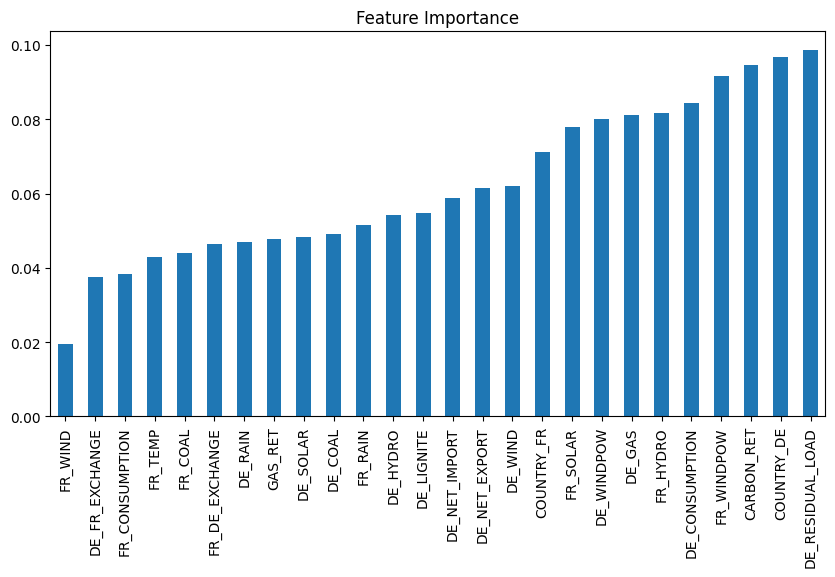

In [321]:
model = CV_XGB_MSE['model']
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)
# Perform permutation importance
results = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42)
# Get importance scores
importance_scores = results.importances_mean
# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()
importances.plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance')
plt.show()

# Target Predictions that work better than mine

97.2296669921627
Model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


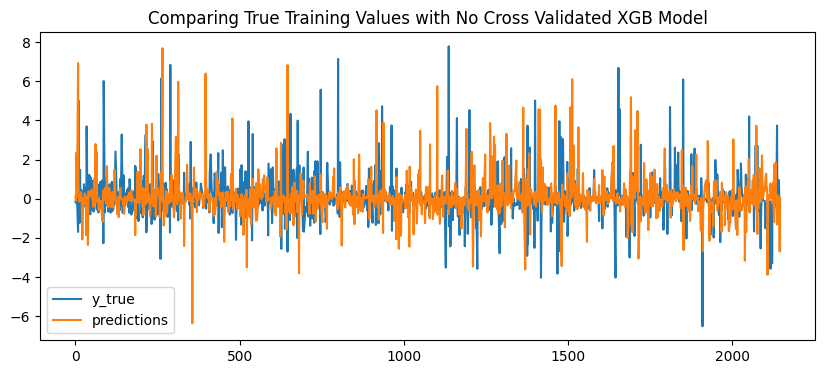

In [316]:
# Simple Model
xgb= XGBRegressor(objective='reg:squarederror', )
xgb.fit(X_clean, Y_clean)
predictions = xgb.predict(X_clean)
y = y.sort_index()
predictions_df = pd.DataFrame(predictions, index=y.index)
print(metric_train(predictions, Y_clean))

plt.figure(figsize=(10,4))
plt.plot(y['TARGET'], label='y_true')
plt.plot(predictions_df, label='predictions')
plt.legend()
plt.title("Comparing True Training Values with No Cross Validated XGB Model")
print("Model parameters:", xgb.get_params())

68.02832382296857


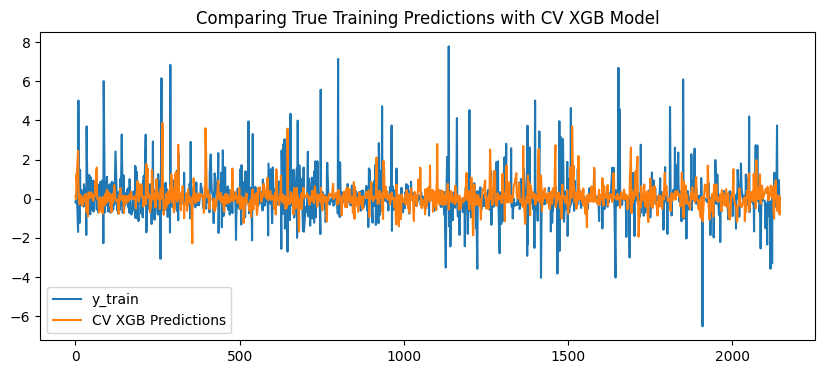

In [311]:
# Comparing Training Preditions with CV XGB Model
training_predictions = pd.DataFrame(CV_XGB_MSE['Training Prediction'], index=y.index)

plt.figure(figsize=(10, 4))
plt.plot(y['TARGET'], label='y_train')
plt.plot(training_predictions, label='CV XGB Predictions')
plt.legend()
plt.title("Comparing True Training Predictions with CV XGB Model")
print(metric_train(training_predictions, Y_clean))

52.51994814903931


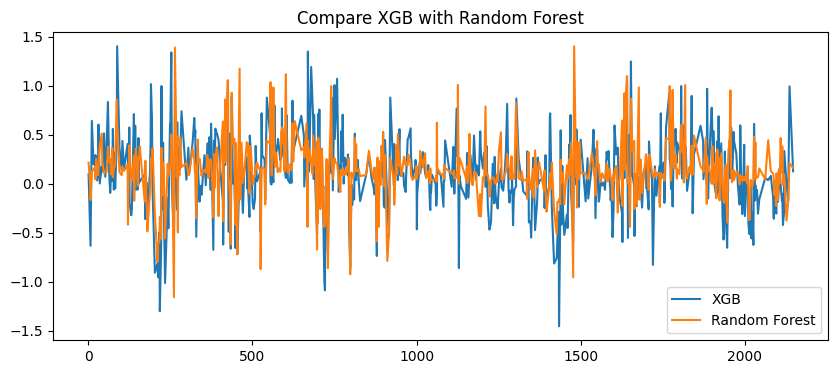

In [312]:
cross_validated_model = cross_validated_model.sort_values(by='ID')
random_forest = pd.read_csv("src/Randon_Forest_model.csv")
random_forest = random_forest.sort_values(by='ID')
plt.figure(figsize=(10, 4))
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='XGB')
plt.plot(random_forest['ID'], random_forest['TARGET'], label='Random Forest')
plt.legend()
plt.title("Compare XGB with Random Forest")
print(metric_train(random_forest['TARGET'], cross_validated_model['TARGET']))

40.29006804600885


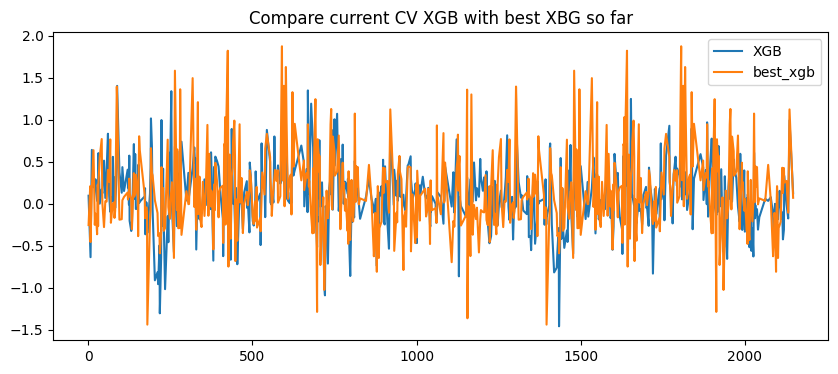

In [317]:
best_xgb = pd.read_csv("xgb_best_predictions.csv")
best_xgb = best_xgb.sort_values(by='ID')
plt.figure(figsize=(10, 4))
plt.plot(cross_validated_model['ID'], cross_validated_model['TARGET'], label='XGB')
plt.plot(best_xgb['ID'], best_xgb['TARGET'], label='best_xgb')
plt.legend()
plt.title("Compare current CV XGB with best XBG so far")
print(metric_train(best_xgb['TARGET'], cross_validated_model['TARGET']))

In [320]:
print("The Volatiltity of Random Forest Predictions: ", np.std(random_forest['TARGET']))
print("The Volatiltity of CV XGB Predictions: ", np.std(cross_validated_model['TARGET']))
print("The Volatiltity of best XGB Predictions: ", np.std(best_xgb['TARGET']))
print("The Volatiltity of Training Target Variable: ", np.std(y['TARGET']))

The Volatiltity of Random Forest Predictions:  0.29756105838991925
The Volatiltity of CV XGB Predictions:  0.38306797
The Volatiltity of best XGB Predictions:  0.4881567240634807
The Volatiltity of Training Target Variable:  1.0342359850681548
